time: 1
time: 2
time: 3
time: 4
time: 5
time: 6
time: 7
time: 8
time: 9
time: 10
time: 11
time: 12
time: 13
time: 14
time: 15
time: 16
time: 17
time: 18
time: 19
time: 20
time: 21
time: 22
time: 23
time: 24
time: 25
time: 26
time: 27
time: 28
time: 29
time: 30
time: 31
time: 32
time: 33
time: 34
time: 35
time: 36
time: 37
time: 38
time: 39
time: 40
time: 41
time: 42
time: 43
time: 44
time: 45
time: 46
time: 47
time: 48
time: 49
time: 50
time: 51
time: 52
time: 53
time: 54
time: 55
time: 56
time: 57
time: 58
time: 59
time: 60
time: 61
time: 62
time: 63
time: 64
time: 65
time: 66
time: 67
time: 68
time: 69
time: 70
time: 71
time: 72
time: 73
time: 74
time: 75
time: 76
time: 77
time: 78
time: 79
time: 80
time: 81
time: 82
time: 83
time: 84
time: 85
time: 86
time: 87
time: 88
time: 89
time: 90
time: 91
time: 92
time: 93
time: 94
time: 95
time: 96
time: 97
time: 98
time: 99
time: 100
time: 101
time: 102
time: 103
time: 104
time: 105
time: 106
time: 107
time: 108
time: 109
time: 110
time: 11

AttributeError: module 'matplotlib.pyplot' has no attribute 'xlable'

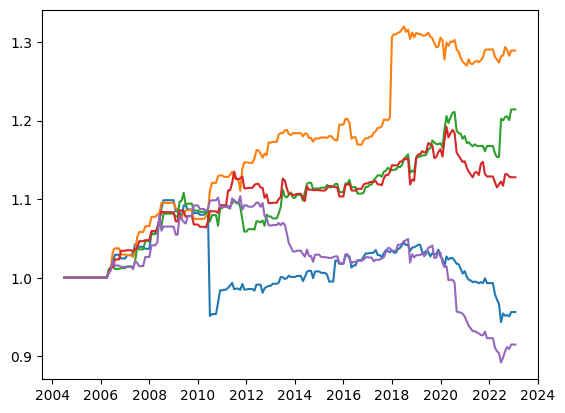

In [3]:
import json
import os   
import math
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
import datetime as dt
import matplotlib.pyplot as plt


class global_multifactor_protfolio():
    def __init__(self, periods=1, weight=[1], tag=['COUNTRY'], factors=['avg_sent']):
        self.periods = periods
        self.weight = weight
        self.tag = tag
        self.factors = factors
        self.path = os.path.abspath('.')
        # self.start_time = dt.datetime(year=2004, month=5, day=31, hour=23, minute=59, second=59)
        # self.end_time = dt.datetime(year=2023, month=1, day=28, hour=23, minute=59, second=59)
        self.length = 224
        # self.time_line = [self.start_time + i * relativedelta(months=1) for i in range(self.length + 1)]
        self.time_line = pd.date_range(start='2004-05-31', freq='M', periods=self.length + 1)
        self.group_number = 5
        self.period_return = np.zeros((self.group_number**len(self.factors), self.length))
        self.total_return = 0
        self.equity = 0

        # self.data = pd.read_csv("Factors.csv")
        # self.columns = self.data.columns
        # self.data["FILING_DATE"] = pd.to_datetime(self.data["FILING_DATE"])
        self.data = pd.read_csv("Factors.csv", parse_dates=["FILING_DATE"])
        self.data = self.data[["TRADINGITEMID", "FILING_DATE"] + self.tag + self.factors]
        self.columns = self.data.columns
        id_in_data = self.data["TRADINGITEMID"].unique().tolist()
        self.stock_price, self.valid_id = self._split(id_in_data)
        # data: "TRADINGITEMID", "FILING_DATE", tag, factors
        # stock_price: "TRADINGITEMID", "PRICEDATE", "ADJ_OPEN", "ADJ_CLOSE"

# 按照tag进行分割
    def get_divided_list(self):
        divided_list = [self.data]
        for t in self.tag:
            comb = []
            for data in divided_list:
                _, tag_dict, tag_dict_note = self._classify(data, t, self.path, if_save=False)
                tag_with_few_samples = tag_dict_note[t + "_with_few_samples"]
                for key in tag_dict:
                    if key in tag_with_few_samples:
                        pass
                    else:
                        # comb.append(np.array(tag_dict[key]))
                        comb.append(pd.DataFrame(tag_dict[key],columns=self.columns))
            divided_list = comb
        divided_list = [df.values for df in divided_list]
        return divided_list

    def run(self):
        base_index = 2 + len(self.tag)
        data_list = self.get_divided_list()
        for time in range(self.periods, self.length - 1):
            print('time:',time)
            stock_number = np.zeros((self.group_number**len(self.factors)))
            log_return = np.zeros((self.group_number**len(self.factors)))
            # open_price = np.zeros((5))
            # close_price = np.zeros((5))
            # time_nodes = self.time_line[time - self.periods:time + 1]
            for data in data_list:
                stock_pool = []
                for i in range(self.periods):
                    start = self.time_line[time - i - 1]
                    end = self.time_line[time - i]
                    mask1 = data[:, 1] > start
                    mask2 = data[:, 1] <= end
                    selected_data = data[mask1 & mask2, :]
                    selected_data[:, base_index:] = selected_data[:, base_index:] * self.weight[i]
                    if len(stock_pool) == 0:
                        stock_pool = selected_data
                    else:
                        stock_pool = np.row_stack((stock_pool, selected_data))
                if len(stock_pool) < 50:
                    continue
                with_price = []
                log_return_list = []
                id_list = []
                for index in range(len(stock_pool)):
                    if stock_pool[index, 0] in self.valid_id and not stock_pool[index, 0] in id_list:
                        id_list.append(stock_pool[index, 0])
                        price = self.stock_price[str(stock_pool[index, 0])]
                        if self.time_line[time + 1] < price[0, 1]:
                            with_price.append(False)
                            continue
                        elif self.time_line[time] > price[-1, 1]:
                            with_price.append(False)
                            continue

                        # info = price[price[:,1]==self.time_line[time+1]]
                        info = price[price[:, 1] > self.time_line[time]]
                        info = info[info[:, 1] <= self.time_line[time + 1]]
                        if len(info) > 0 and info[0, 3] != 0 and info[0, 2] != 0:
                            lr = np.log(info[0, 3] / info[0, 2]) #log return 
                            if np.isnan(lr):
                                with_price.append(False)
                            else:
                                with_price.append(True)
                                log_return_list.append(lr)
                        else:
                            with_price.append(False)
                    else:
                        with_price.append(False)
                if len(log_return_list) < 50:
                    continue
                stock_pool = np.column_stack((stock_pool[with_price],np.array(log_return_list)))
                grouped_by_factor = [stock_pool]
                for j in range(len(self.factors)):
                    new_grouped_result = []
                    for group in grouped_by_factor:
                        group = group[np.argsort(group[:, base_index + j]), :]#按照指定行sort
                        gap = int(len(group) / self.group_number)
                        for n in range(self.group_number-1):
                            new_grouped_result.append(group[n * gap:(n + 1) * gap, :])
                        new_grouped_result.append(group[(self.group_number - 1) * gap:, :])
                    grouped_by_factor = new_grouped_result
                for m in range(self.group_number**len(self.factors)):
                    stock_number[m]=stock_number[m]+len(grouped_by_factor[m])
                    log_return[m] = log_return[m] + np.sum(grouped_by_factor[m][:,-1])
            if np.sum(stock_number) == 0:
                self.period_return[:,time] = log_return
            else:
                self.period_return[:,time] = log_return/stock_number

        self.total_return = self.period_return.cumsum(axis=1)
        self.equity = np.exp(self.total_return)

        # for s in range(self.group_number):
        #     plt.figure()
        #     for o in range(self.group_number):
        #         plt.plot(self.time_line[1:],e[s*self.group_number+o,:],label=str(o+1)+'q')
        #     plt.legend()
        #     plt.show()
        #     input()
        #     plt.close()


    # _________________________________________________________________________________________
    def _classify(self, data, classification_tag, path, if_save=True):
        """
        Use a specific tag to split data and save the results
        :param data: pd.DataFrame: raw data
        :param classification_tag: str: "SECTOR"  "REGION"  "COUNTRY"
        :param path: str: the absolute path to save results
        :param if_save: Bool: weather save the result or not
        :return: data_with_tag: pd.DataFrame, tag_dict: dict, tag_dict_note: dict
        """

        if classification_tag == None:
            return 0

        #  split by tag
        note = ""
        tag_name = data[classification_tag].values
        tag_select = [True if isinstance(sn, str) else False for sn in tag_name]
        data_with_tag = data.iloc[tag_select, :]
        tag_name = np.unique(tag_name[tag_select])
        tag_dict = {key: data.loc[data[classification_tag].values == key].values.tolist() for key in tag_name}
        tag_with_few_samples_index = [True if len(tag_dict[key]) < 2000 else False for key in tag_name]
        tag_with_few_samples = tag_name[tag_with_few_samples_index].tolist()
        note += "There are " + str(
            len(data) - len(data_with_tag)) + " reports without tagging of " + classification_tag + ".\n"
        note += "There are " + str(len(data_with_tag)) + " reports with tagging of " + classification_tag + ".\n"
        tag_dict_note = {"columns_name": data.columns.values.tolist(),
                         classification_tag + "_name": tag_name.tolist(),
                         "Number_of_" + classification_tag: len(tag_name),
                         classification_tag + "_with_few_samples": tag_with_few_samples,
                         "Number_of_" + classification_tag + "_with_few_samples": len(tag_with_few_samples),
                         "note": note}

        #  save file
        if if_save:
            folder_name = classification_tag + "_Classification"
            folder_list = [x for x in os.listdir(path) if os.path.isdir(x)]
            if folder_name not in folder_list:
                os.mkdir(os.path.join(path, folder_name))
            sub_path = os.path.join(path, classification_tag + "_Classification")

            json_str = json.dumps(tag_dict)
            with open(os.path.join(sub_path, classification_tag + '_Classification.json'), 'w',
                      encoding='utf-8') as json_file:
                json_file.write(json_str)
                json_file.close()
            json_str = json.dumps(tag_dict_note)
            with open(os.path.join(sub_path, classification_tag + '_Classification_Note.json'), 'w',
                      encoding='utf-8') as json_file:
                json_file.write(json_str)
                json_file.close()

            data_with_tag.to_csv(os.path.join(sub_path, "Data_with_" + classification_tag + "_Tag.csv"),
                                 encoding="utf-8", index=False)

        return data_with_tag, tag_dict, tag_dict_note

    def _break_point(self, end_point, data, n, index):
        for i in range(n):
            if i < n - 1:
                if data[i, 0] != data[i + 1, 0]:
                    end_point.append(i)
                    index += 1
            else:
                end_point.append(i)

        return end_point

    def _split(self, stock_id):
        data = pd.read_csv("Monthly_Price.csv", parse_dates=["PRICEDATE"])
        # data["PRICEDATE"] = pd.to_datetime(data["PRICEDATE"])
        data = data[["TRADINGITEMID", "PRICEDATE", "ADJ_OPEN", "ADJ_CLOSE"]].values
        n = len(data)
        index = 0
        end_point = []
        end_point = self._break_point(end_point, data, n, index)

        start = 0
        valid_id = []
        stock_price = {}
        for end in end_point:
            id = data[end, 0]
            if id in stock_id:
                valid_id.append(id)
                # stock_price[str(id)]=pd.DataFrame(data[start:end + 1, :], columns=col)
                stock_price[str(id)] = data[start:end + 1, :]
            start = end + 1

        return stock_price, valid_id


if __name__ == '__main__':
    # tag: country sector country+sector region+sector exchangename+country
    # factor: avg_sent sum_sent word_count+avgsent ...
    portfolio = global_multifactor_protfolio(periods=1,weight=[1]*1,tag=["SECTOR"],factors=['word_count'])
    
    # portfolio.data = pd.read_csv()
    portfolio.run()



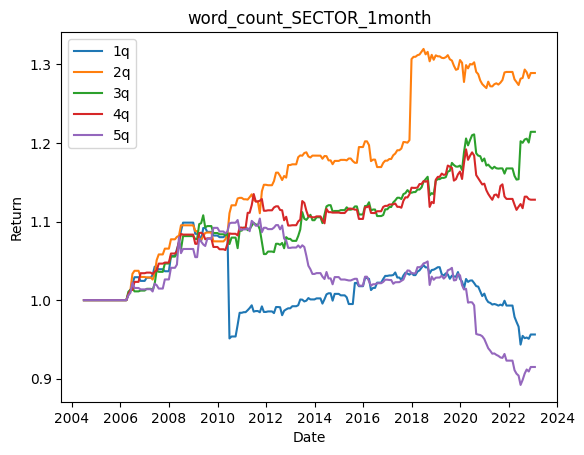

portfolio_1's sharp ratio: -1.7755720827537096 return: -0.059738237711075656
portfolio_2's sharp ratio: 2.735171796480637 return: 0.2730535816961561
portfolio_3's sharp ratio: 3.4354361064030856 return: 0.19821515396447853
portfolio_4's sharp ratio: 2.338773847395256 return: 0.11182163294948923
portfolio_5's sharp ratio: -2.0442433281035073 return: -0.10108900327674185


In [8]:
plt.figure()
for o in range(len(portfolio.equity)):
    plt.plot(portfolio.time_line[1:],portfolio.equity[o,:],label=str(o+1)+'q')
plt.xlabel("Date")
plt.ylabel("Return")
plt.title(str(portfolio.factors[0])+"_"+str(portfolio.tag[0])+"_"+str(portfolio.periods)+"month")
plt.legend()
plt.savefig("./data/"+str(portfolio.factors[0])+"_"+str(portfolio.tag[0])+"_"+str(portfolio.periods)+"month"+".png")
plt.show()

for i in range(portfolio.equity.shape[0]):
    rf=0.016
    return_v=portfolio.equity[i][-1]-1-rf
    std_v=np.std(portfolio.equity[i])
    sharp=return_v/std_v
    print("portfolio_"+str(i+1)+"'s sharp ratio: "+ str(sharp)+" return: "+str(return_v))
# portfolio.time_line